In [30]:
import pandas as pd
import numpy as np
from matplotlib import pyplot as plt
from scipy.cluster.hierarchy import dendrogram, linkage
from scipy.spatial.distance import pdist, squareform
import pickle
import itertools
import scipy.stats as scs
from scipy.spatial.distance import pdist, squareform
from sklearn.cluster import KMeans 
from sklearn.metrics import silhouette_score, silhouette_samples
import matplotlib
from src.date_util import str_to_float as string_to_epoch
from IPython.display import HTML, display
import warnings
warnings.filterwarnings('ignore')
%matplotlib inline

In [31]:
with open('../data/csgo_df.pkl', 'rb') as f:
    df = pickle.load(f)

### Make a copy that I don't manipulate

In [32]:
df_raw = df.copy()

### Drop items with missing release date, low quantity, and minimum price

In [33]:
df = df.reset_index(drop=True)

In [34]:
display(df.info())
df.head()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 8881814 entries, 0 to 8881813
Data columns (total 6 columns):
app                  int64
date                 float64
item_name            object
median_sell_price    float64
quantity             int64
release_date         object
dtypes: float64(2), int64(2), object(2)
memory usage: 406.6+ MB


None

,app,date,item_name,median_sell_price,quantity,release_date
0,730,1.471583e+09,Glock-18 | Weasel (Battle-Scarred),6.193,135,18 August 2016
1,730,1.471669e+09,Glock-18 | Weasel (Battle-Scarred),5.103,166,18 August 2016
2,730,1.471756e+09,Glock-18 | Weasel (Battle-Scarred),4.721,142,18 August 2016
3,730,1.471842e+09,Glock-18 | Weasel (Battle-Scarred),4.302,98,18 August 2016
4,730,1.471928e+09,Glock-18 | Weasel (Battle-Scarred),3.898,125,18 August 2016


In [35]:
df = df.dropna()
df = df.reset_index(drop=True)

In [36]:
display(df.info())
df.head()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 5825872 entries, 0 to 5825871
Data columns (total 6 columns):
app                  int64
date                 float64
item_name            object
median_sell_price    float64
quantity             int64
release_date         object
dtypes: float64(2), int64(2), object(2)
memory usage: 266.7+ MB


None

,app,date,item_name,median_sell_price,quantity,release_date
0,730,1.471583e+09,Glock-18 | Weasel (Battle-Scarred),6.193,135,18 August 2016
1,730,1.471669e+09,Glock-18 | Weasel (Battle-Scarred),5.103,166,18 August 2016
2,730,1.471756e+09,Glock-18 | Weasel (Battle-Scarred),4.721,142,18 August 2016
3,730,1.471842e+09,Glock-18 | Weasel (Battle-Scarred),4.302,98,18 August 2016
4,730,1.471928e+09,Glock-18 | Weasel (Battle-Scarred),3.898,125,18 August 2016


In [37]:
df['min_quant'] = df.groupby('item_name')['quantity'].transform('min')
df['min_price'] = df.groupby('item_name')['median_sell_price'].transform('min')
df = df[df.min_quant > 60]
df = df[df.min_price > 0.4]

In [38]:
df = df.reset_index(drop=True)
display(df.info())
display(df.head())
print('Number of items: ' + str(len(df.item_name.unique())))

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 91372 entries, 0 to 91371
Data columns (total 8 columns):
app                  91372 non-null int64
date                 91372 non-null float64
item_name            91372 non-null object
median_sell_price    91372 non-null float64
quantity             91372 non-null int64
release_date         91372 non-null object
min_quant            91372 non-null int64
min_price            91372 non-null float64
dtypes: float64(3), int64(3), object(2)
memory usage: 5.6+ MB


None

,app,date,item_name,median_sell_price,quantity,release_date,min_quant,min_price
0,730,1.471583e+09,StatTrak™ P90 | Grim (Field-Tested),7.559,153,18 August 2016,95,0.454
1,730,1.471669e+09,StatTrak™ P90 | Grim (Field-Tested),5.642,179,18 August 2016,95,0.454
2,730,1.471756e+09,StatTrak™ P90 | Grim (Field-Tested),4.711,150,18 August 2016,95,0.454
3,730,1.471842e+09,StatTrak™ P90 | Grim (Field-Tested),4.308,140,18 August 2016,95,0.454
4,730,1.471928e+09,StatTrak™ P90 | Grim (Field-Tested),3.919,138,18 August 2016,95,0.454


Number of items: 113


### Drop first 100 entries for each item

In [39]:
df['item_index'] = np.nan

In [40]:
df['item_index'] = df.groupby('item_name').transform(lambda x: np.arange(len(x)))

In [41]:
df = df[df['item_index'] > 100]

In [42]:
df = df.reset_index(drop=True)
display(df.info())
display(df.head())
print('Number of items: ' + str(len(df.item_name.unique())))

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 79959 entries, 0 to 79958
Data columns (total 9 columns):
app                  79959 non-null int64
date                 79959 non-null float64
item_name            79959 non-null object
median_sell_price    79959 non-null float64
quantity             79959 non-null int64
release_date         79959 non-null object
min_quant            79959 non-null int64
min_price            79959 non-null float64
item_index           79959 non-null int64
dtypes: float64(3), int64(4), object(2)
memory usage: 5.5+ MB


None

,app,date,item_name,median_sell_price,quantity,release_date,min_quant,min_price,item_index
0,730,1.480313e+09,StatTrak™ P90 | Grim (Field-Tested),0.971,166,18 August 2016,95,0.454,101
1,730,1.480399e+09,StatTrak™ P90 | Grim (Field-Tested),0.918,250,18 August 2016,95,0.454,102
2,730,1.480486e+09,StatTrak™ P90 | Grim (Field-Tested),0.971,269,18 August 2016,95,0.454,103
3,730,1.480572e+09,StatTrak™ P90 | Grim (Field-Tested),1.017,241,18 August 2016,95,0.454,104
4,730,1.480658e+09,StatTrak™ P90 | Grim (Field-Tested),1.025,274,18 August 2016,95,0.454,105


Number of items: 113


---

### Cluster items that existed in 2016

In [43]:
df_dates = df[[(x >= string_to_epoch('01 Jan 2016')) and (x <= string_to_epoch('31 Dec 2016')) for x in df.date]]

In [44]:
df_dates['info'] = df_dates['item_name'] + ' ' + df_dates['release_date']

In [45]:
df_dates.release_date.unique()

array(['18 August 2016', '27 April 2016', '17 February 2016',
       '18 December 2013', '15 June 2016', '17 September 2015',
       '20 February 2014', '1 May 2014', '1 July 2014', '10 July 2014',
       '15 April 2015', '8 January 2015', '11 November 2014',
       '26 May 2015', '8 December 2015'], dtype=object)

In [46]:
df_pivot = df_dates.reset_index().pivot('info', 'date', 'median_sell_price')

In [47]:
df_pivot.head()

date,1451628000.0,1451714400.0,1451800800.0,1451887200.0,1451973600.0,1452060000.0,1452146400.0,1452232800.0,1452319200.0,1452405600.0,...,1482386400.0,1482472800.0,1482559200.0,1482645600.0,1482732000.0,1482818400.0,1482904800.0,1482991200.0,1483077600.0,1483164000.0
info,,,,,,,,,,,,,,,,,,,,,
AK-47 | Aquamarine Revenge (Field-Tested) 26 May 2015,20.327,19.597,18.522,18.518,19.864,20.389,20.728,20.562,20.895,20.167,...,12.378,12.029,13.447,14.921,14.855,14.530,14.624,14.748,14.755,15.000
AK-47 | Blue Laminate (Factory New) 18 December 2013,2.151,2.070,2.038,2.067,2.314,2.348,2.297,2.341,2.340,2.374,...,2.933,2.676,2.848,3.115,3.129,3.112,3.126,3.048,2.924,2.992
AK-47 | Blue Laminate (Field-Tested) 18 December 2013,1.368,1.331,1.301,1.309,1.523,1.591,1.627,1.625,1.651,1.690,...,2.078,1.899,2.024,2.117,2.123,2.066,2.139,2.197,2.136,2.122
AK-47 | Blue Laminate (Minimal Wear) 18 December 2013,1.486,1.457,1.405,1.451,1.658,1.719,1.720,1.742,1.748,1.770,...,2.159,1.997,2.165,2.205,2.259,2.230,2.255,2.319,2.243,2.218
AK-47 | Cartel (Field-Tested) 8 January 2015,1.475,1.407,1.389,1.439,1.689,1.715,1.717,1.739,1.787,1.863,...,1.988,1.839,1.919,2.072,2.105,2.077,2.130,2.152,2.137,2.162


In [48]:
df_pivot = df_pivot.dropna()

In [49]:
df_pivot.head()

date,1451628000.0,1451714400.0,1451800800.0,1451887200.0,1451973600.0,1452060000.0,1452146400.0,1452232800.0,1452319200.0,1452405600.0,...,1482386400.0,1482472800.0,1482559200.0,1482645600.0,1482732000.0,1482818400.0,1482904800.0,1482991200.0,1483077600.0,1483164000.0
info,,,,,,,,,,,,,,,,,,,,,
AK-47 | Aquamarine Revenge (Field-Tested) 26 May 2015,20.327,19.597,18.522,18.518,19.864,20.389,20.728,20.562,20.895,20.167,...,12.378,12.029,13.447,14.921,14.855,14.530,14.624,14.748,14.755,15.000
AK-47 | Blue Laminate (Factory New) 18 December 2013,2.151,2.070,2.038,2.067,2.314,2.348,2.297,2.341,2.340,2.374,...,2.933,2.676,2.848,3.115,3.129,3.112,3.126,3.048,2.924,2.992
AK-47 | Blue Laminate (Field-Tested) 18 December 2013,1.368,1.331,1.301,1.309,1.523,1.591,1.627,1.625,1.651,1.690,...,2.078,1.899,2.024,2.117,2.123,2.066,2.139,2.197,2.136,2.122
AK-47 | Blue Laminate (Minimal Wear) 18 December 2013,1.486,1.457,1.405,1.451,1.658,1.719,1.720,1.742,1.748,1.770,...,2.159,1.997,2.165,2.205,2.259,2.230,2.255,2.319,2.243,2.218
AK-47 | Cartel (Field-Tested) 8 January 2015,1.475,1.407,1.389,1.439,1.689,1.715,1.717,1.739,1.787,1.863,...,1.988,1.839,1.919,2.072,2.105,2.077,2.130,2.152,2.137,2.162


# Find every item that, after removing first 100 days and low quantity, existed between 2016, 2017

In [50]:
def make_dendrogram(dataframe, linkage_method, metric):
    '''
    This function creates and plots the dendrogram created by hierarchical clustering.
    
    INPUTS: Pandas Dataframe, string, string, int
    
    OUTPUTS: None
    '''
    distxy = squareform(pdist(dataframe.values, metric=metric))
    Z = linkage(distxy, linkage_method)
    plt.figure(figsize=(25, 10))
    plt.title('Hierarchical Clustering Dendrogram')
    plt.xlabel('sample index')
    plt.ylabel('distance')
    dendrogram(
        Z,
        leaf_rotation=90.,  # rotates the x axis labels
        leaf_font_size=14.,  # font size for the x axis labels
        labels = dataframe.index
    )
    plt.show()

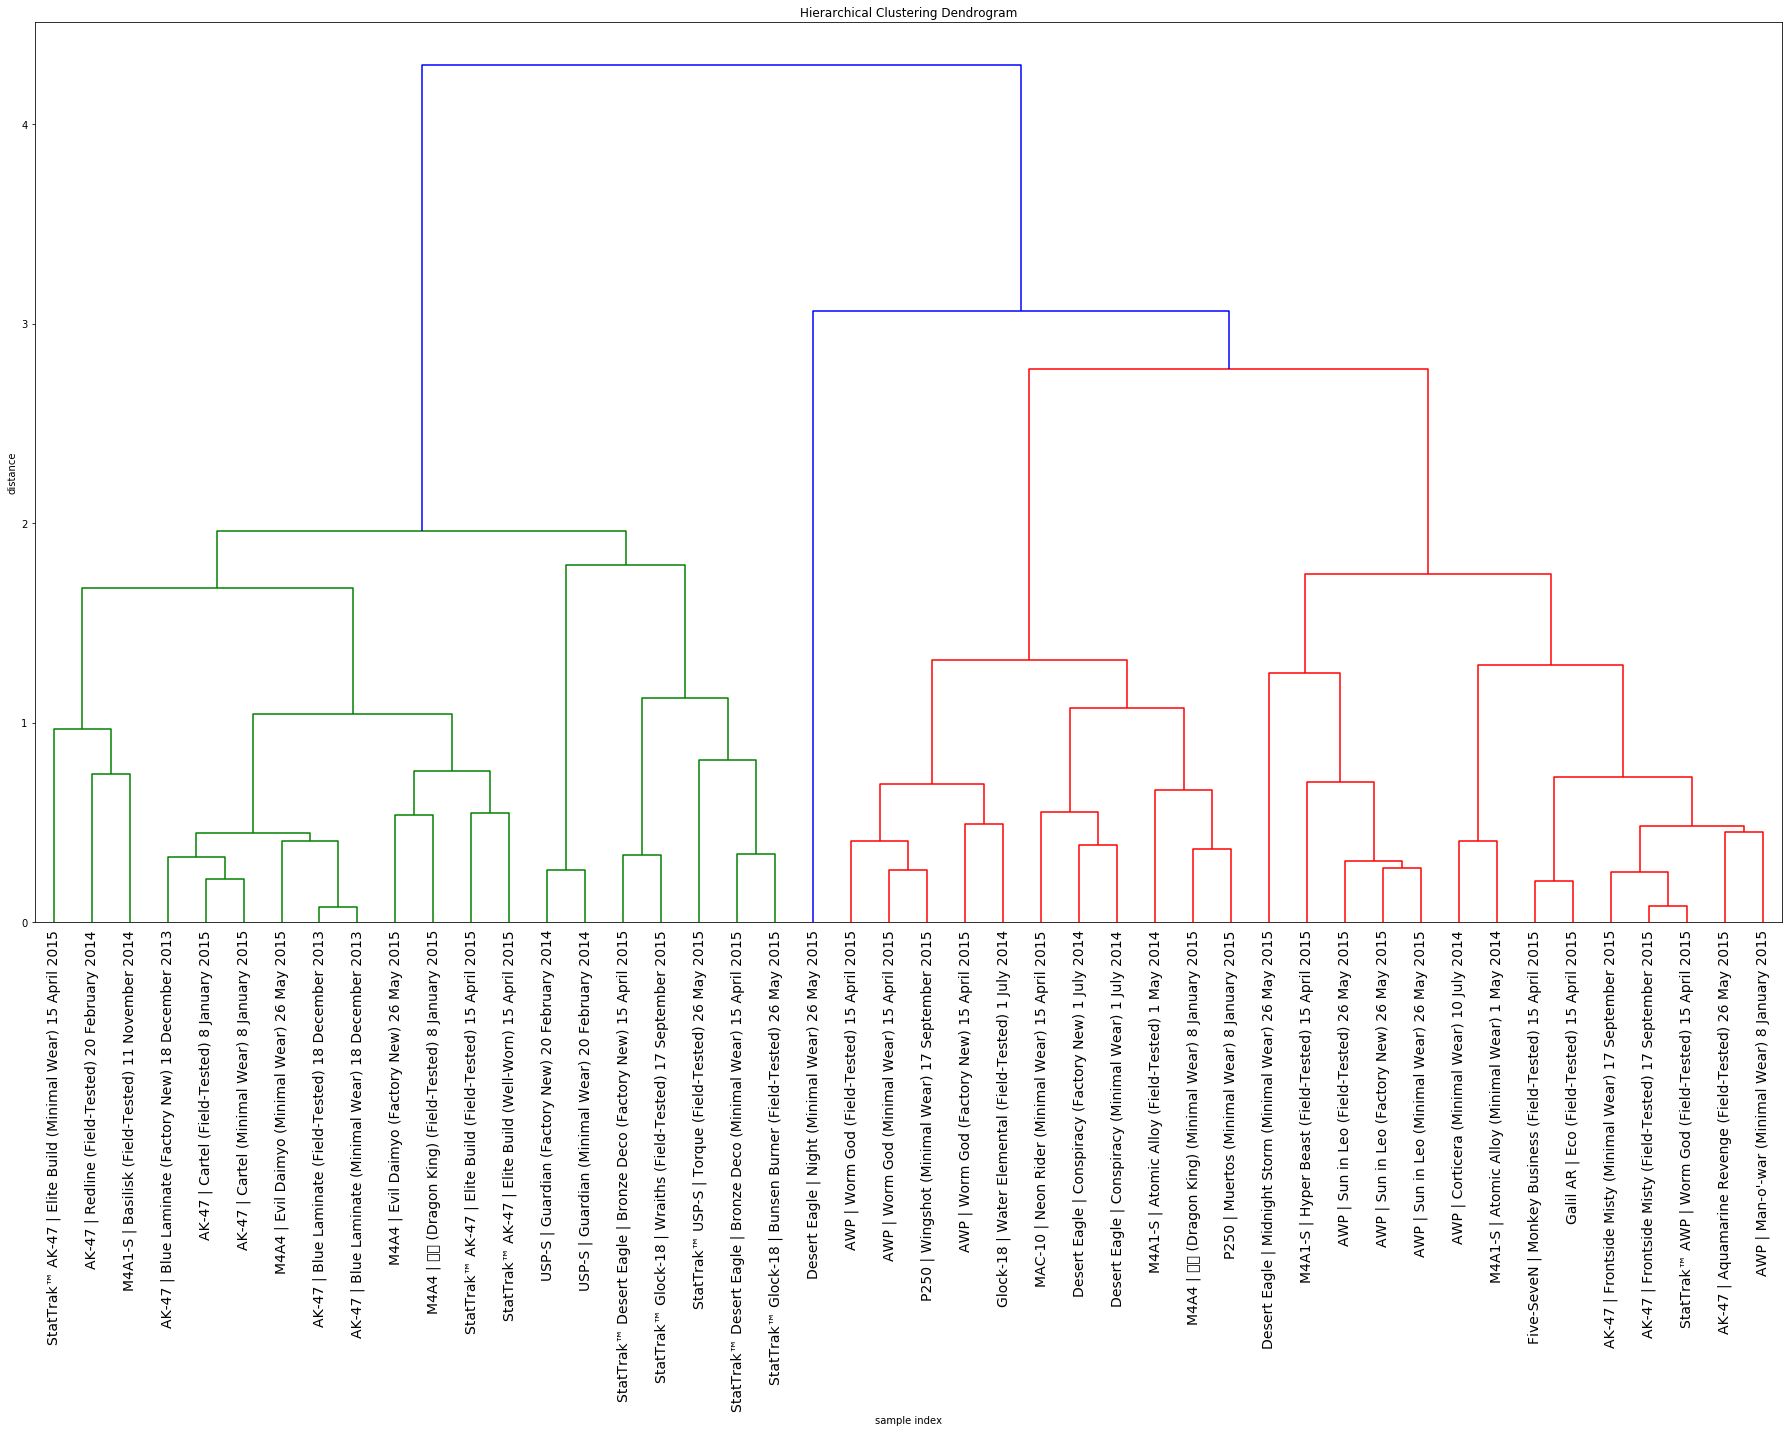

In [51]:
from sklearn.preprocessing import StandardScaler
df_pivot_norm = StandardScaler().fit_transform(df_pivot.transpose()).T
linktype = 'average'
metric = 'cosine'
distxy = squareform(pdist(df_pivot_norm, metric=metric))
Z = linkage(distxy, linktype)
plt.figure(figsize=(25, 20))
plt.title('Hierarchical Clustering Dendrogram')
plt.xlabel('sample index')
plt.ylabel('distance')
dendrogram(
    Z,
    leaf_rotation=90.,  # rotates the x axis labels
    leaf_font_size=14.,  # font size for the x axis labels (was 5 for large sets)
    labels = df_pivot.index,
    color_threshold = None
)
plt.gcf()
plt.tight_layout()
#plt.savefig('dendogram_400_1000', dpi=400, pad_inches=0)

## Look at subsets of the data based on how long they've been on the market, then cluster with the time series shifted relative to date of release

In [52]:
df['num_sale_dates'] = df.groupby('item_name')['item_index'].transform('max')

In [53]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 79959 entries, 0 to 79958
Data columns (total 10 columns):
app                  79959 non-null int64
date                 79959 non-null float64
item_name            79959 non-null object
median_sell_price    79959 non-null float64
quantity             79959 non-null int64
release_date         79959 non-null object
min_quant            79959 non-null int64
min_price            79959 non-null float64
item_index           79959 non-null int64
num_sale_dates       79959 non-null int64
dtypes: float64(3), int64(5), object(2)
memory usage: 6.1+ MB


In [54]:
days_on_market = df['num_sale_dates'].unique()

In [55]:
days_on_market.sort()

In [56]:
days_on_market

array([ 134,  288,  402,  471,  578,  680,  744,  793,  863,  934, 1016,
       1130, 1171, 1268, 1326, 1450, 1459, 1520, 1590, 1654])

In [57]:
df_sub = df[(df['num_sale_dates'] > 400) & (df['num_sale_dates'] < 1000)]

In [58]:
df_sub = df_sub[df_sub['item_index'] <= min(df_sub['num_sale_dates'])]

In [59]:
df_sub['info'] = df_sub['item_name'] + ' ' + df_sub['release_date']

Pivot on the 'item_index' instead of 'date' to shift the time series relative to each other

In [60]:
df_pivot = df_sub.reset_index().pivot('info', 'item_index', 'median_sell_price')

### Looking at the difference in heirarchical clusters when I standardize and when I don't. With cosine similarity I didn't think there would be a difference, but maybe standard scaler is altering more than just the magnitude and relative position of the vectors

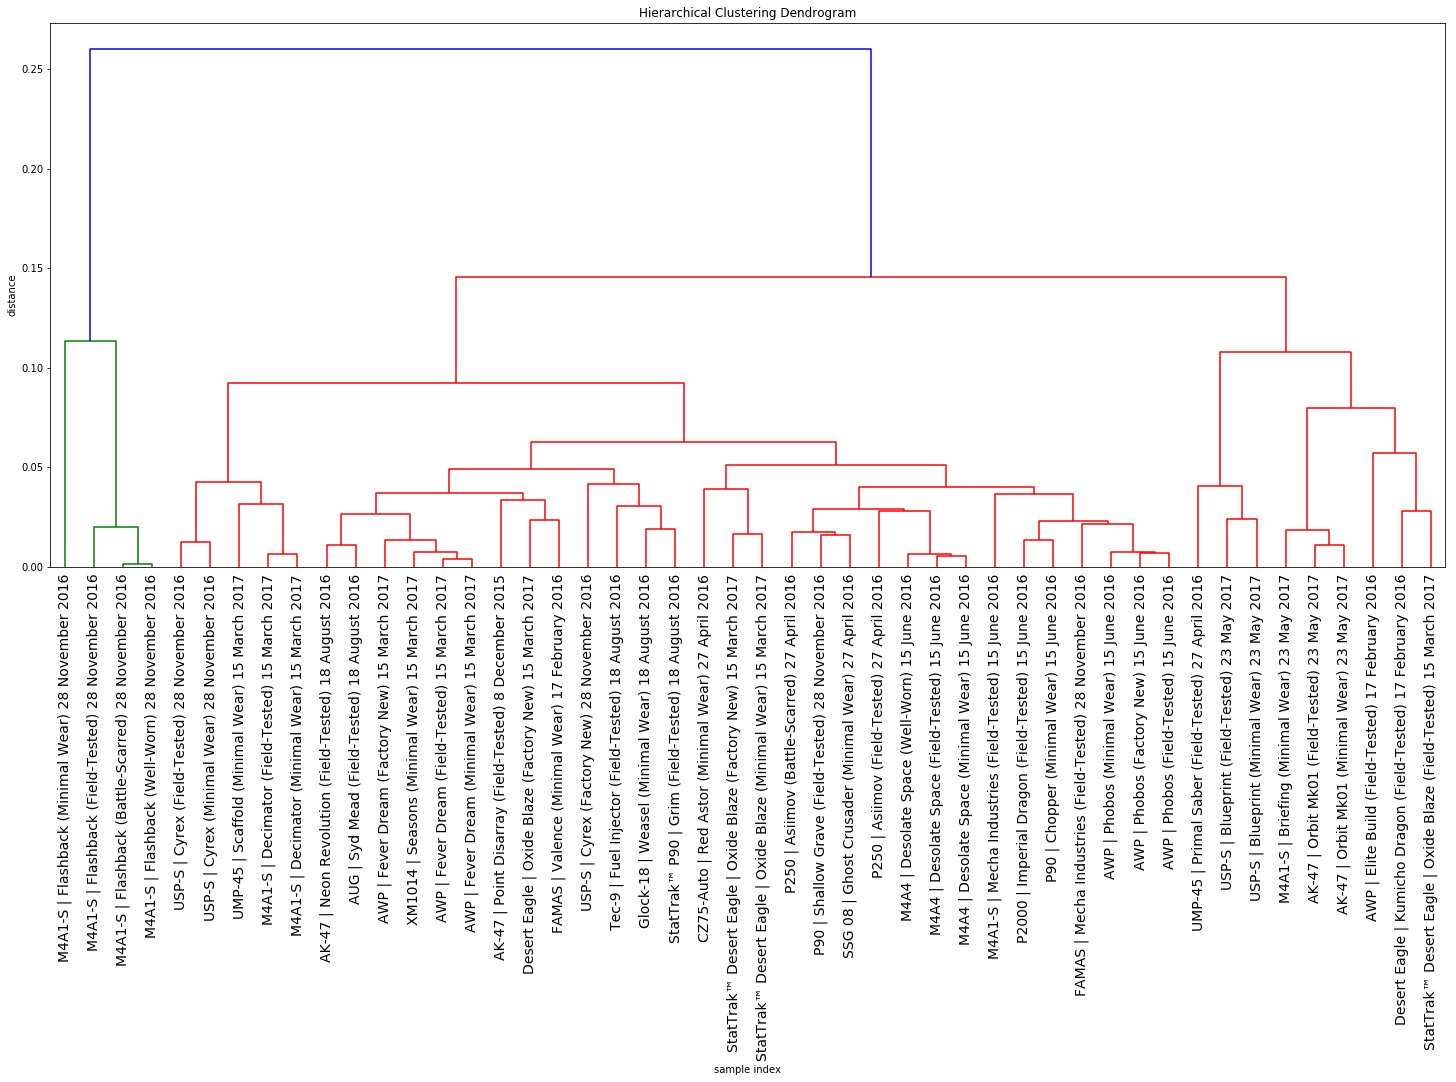

In [61]:
linktype = 'average'
metric = 'cosine'
make_dendrogram(df_pivot, linktype, metric)

#### Scaled

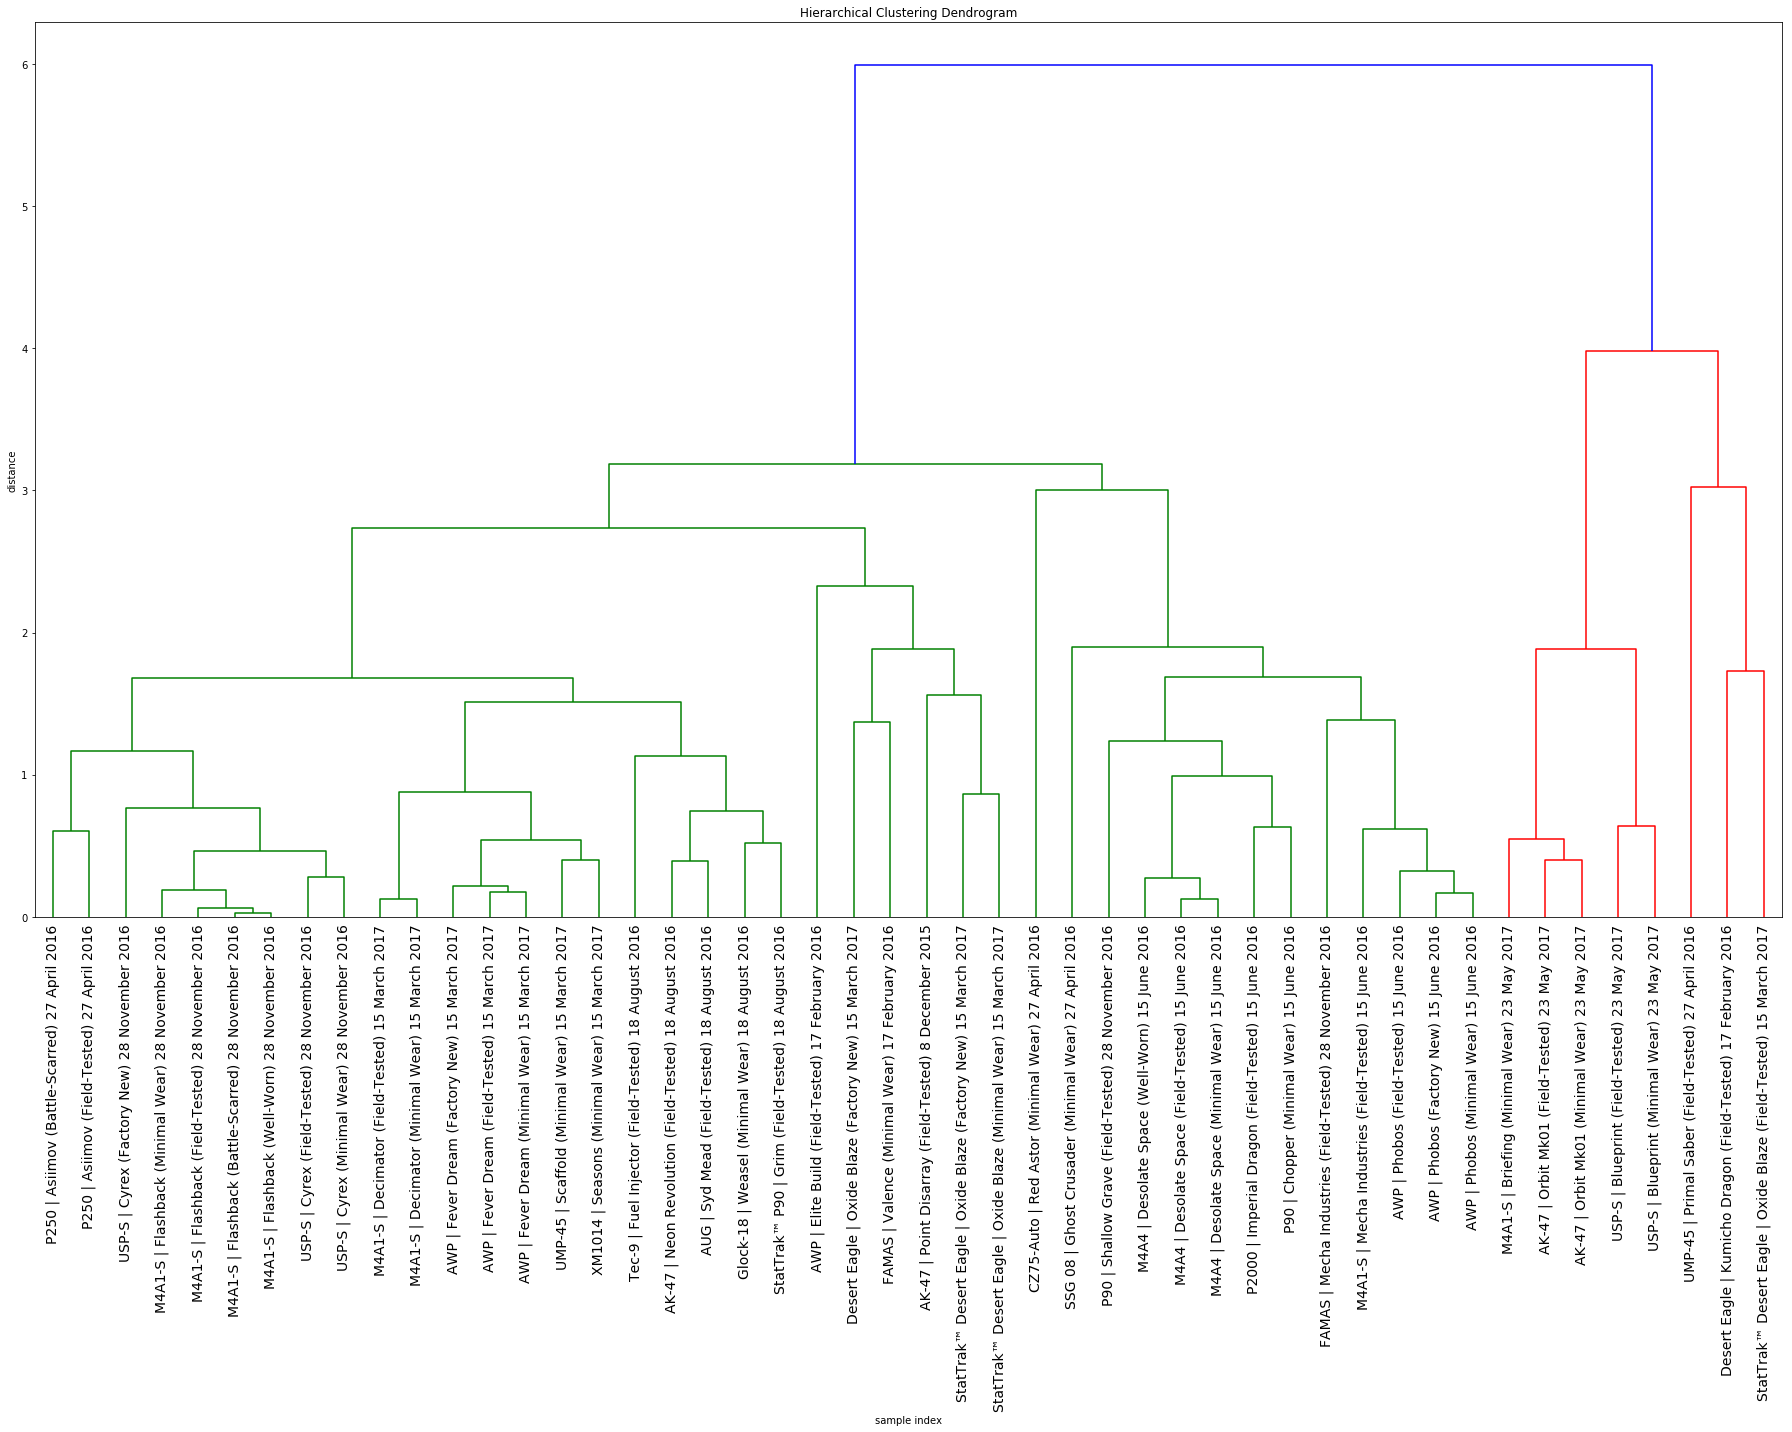

In [62]:
from sklearn.preprocessing import StandardScaler
df_pivot_norm = StandardScaler().fit_transform(df_pivot.transpose()).T
linktype = 'average'
metric = 'cosine'
distxy = squareform(pdist(df_pivot_norm, metric=metric))
Z = linkage(distxy, linktype)
plt.figure(figsize=(25, 20))
plt.title('Hierarchical Clustering Dendrogram')
plt.xlabel('sample index')
plt.ylabel('distance')
dendrogram(
    Z,
    leaf_rotation=90.,  # rotates the x axis labels
    leaf_font_size=14.,  # font size for the x axis labels (was 5 for large sets)
    labels = df_pivot.index
)
plt.gcf()
plt.tight_layout()
#plt.savefig('dendogram_400_1000', dpi=400, pad_inches=0)

#### The above dendrogram showed that the date of sale has more effect than the relative days since release. When I look at the the first *n* sales of several items, they cluster based on the date of release. When I look at 2016-2017, they don't group as strictly on the release date. This tells me the date of sale is more predictive than the number of days on the market

---

#### Why was an item released on Dec 8, 2015 clustered with items released on June 15, 2016?

In [117]:
df_standard = pd.DataFrame(data=df_pivot_norm, index=df_pivot.index, columns=df_pivot.columns)

In [127]:
df_standard.loc[['P2000 | Imperial Dragon (Field-Tested) 8 December 2015', 'M4A1-S | Mecha Industries (Field-Tested) 15 June 2016', 'AWP | Phobos (Factory New) 15 June 2016']].head()

item_index,101,102,103,104,105,106,107,108,109,110,...,468,469,470,471,472,473,474,475,476,477
info,,,,,,,,,,,,,,,,,,,,,
P2000 | Imperial Dragon (Field-Tested) 8 December 2015,0.753628,0.992667,1.119216,1.133277,1.512926,1.463712,1.316071,1.302010,1.161399,0.746598,...,0.163064,0.134941,0.078697,0.156033,-0.047852,0.191186,0.212277,0.732537,0.613018,0.500529
M4A1-S | Mecha Industries (Field-Tested) 15 June 2016,1.042407,1.108118,1.229013,1.130021,1.146804,1.171268,1.110678,1.104988,1.034727,1.086214,...,-0.942269,-0.935158,-0.900738,-0.915245,-0.847828,-0.920935,-0.920935,-0.848113,-0.823934,-0.812271
AWP | Phobos (Factory New) 15 June 2016,1.192654,1.108871,1.194802,1.633051,1.491264,1.602975,1.639495,1.343033,1.381702,1.491264,...,-0.704276,-0.599011,-0.446483,-0.549600,-0.448631,-0.487300,-0.489448,-0.276769,-0.205876,-0.360552


In [128]:
df_pivot.loc[['P2000 | Imperial Dragon (Field-Tested) 8 December 2015', 'M4A1-S | Mecha Industries (Field-Tested) 15 June 2016', 'AWP | Phobos (Factory New) 15 June 2016']].head()

item_index,101,102,103,104,105,106,107,108,109,110,...,468,469,470,471,472,473,474,475,476,477
info,,,,,,,,,,,,,,,,,,,,,
P2000 | Imperial Dragon (Field-Tested) 8 December 2015,1.455,1.489,1.507,1.509,1.563,1.556,1.535,1.533,1.513,1.454,...,1.371,1.367,1.359,1.37,1.341,1.375,1.378,1.452,1.435,1.419
M4A1-S | Mecha Industries (Field-Tested) 15 June 2016,16.262,16.493,16.918,16.570,16.629,16.715,16.502,16.482,16.235,16.416,...,9.285,9.310,9.431,9.38,9.617,9.360,9.360,9.616,9.701,9.742
AWP | Phobos (Factory New) 15 June 2016,3.441,3.402,3.442,3.646,3.580,3.632,3.649,3.511,3.529,3.580,...,2.558,2.607,2.678,2.63,2.677,2.659,2.658,2.757,2.790,2.718


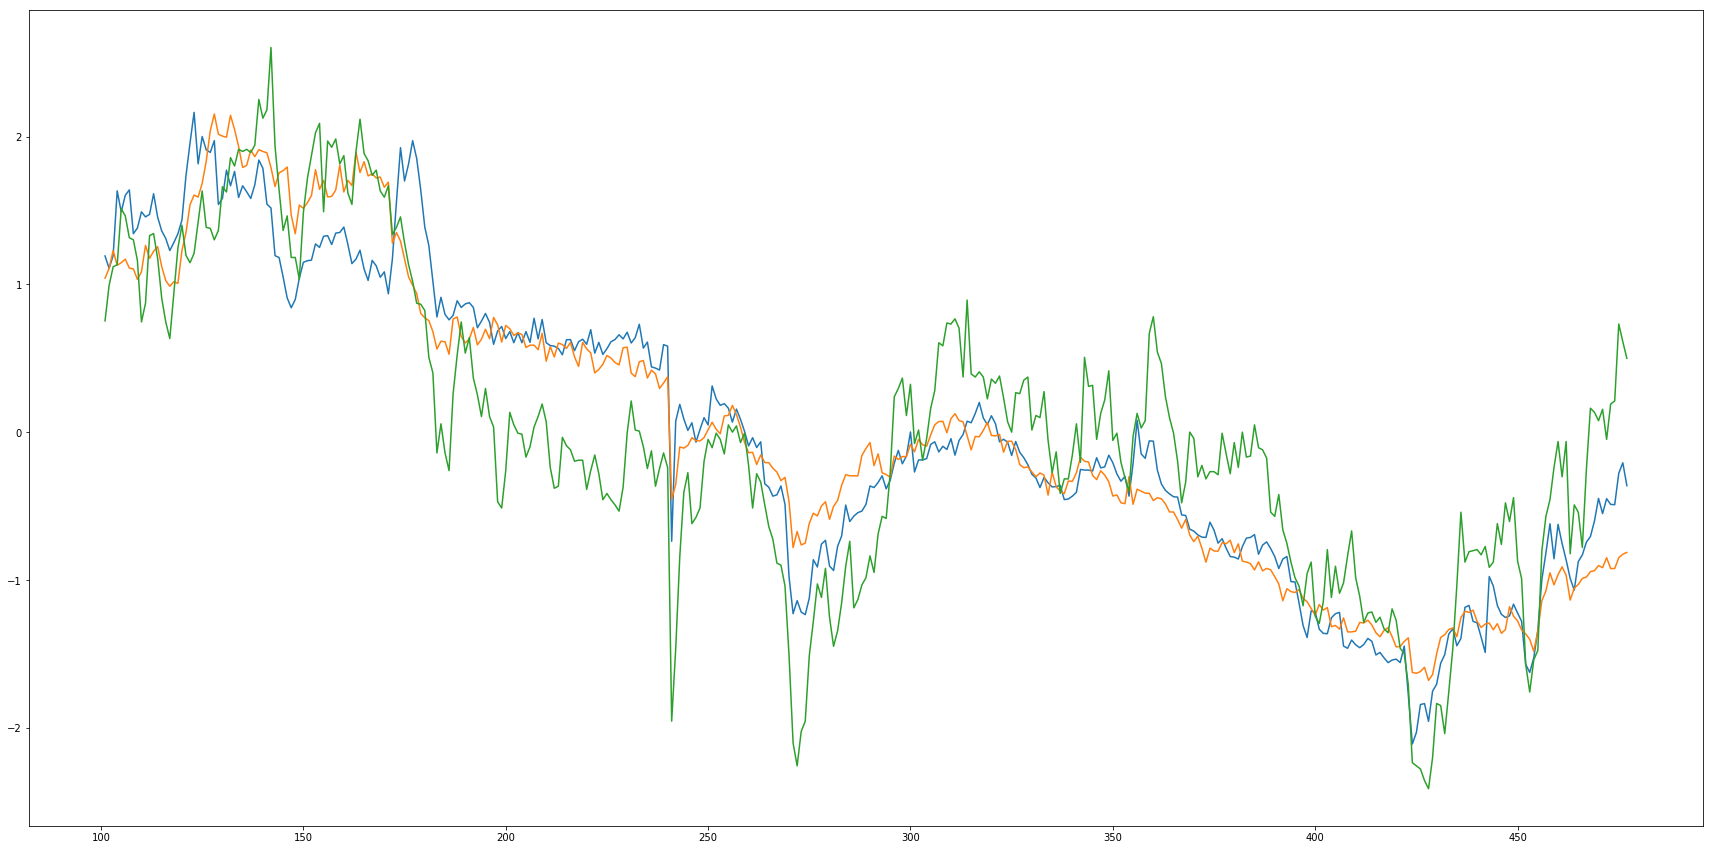

In [120]:
fig, ax = plt.subplots(figsize=(30, 15))
ax.plot(df_standard.loc['AWP | Phobos (Factory New) 15 June 2016'])
ax.plot(df_standard.loc['M4A1-S | Mecha Industries (Field-Tested) 15 June 2016'])
ax.plot(df_standard.loc['P2000 | Imperial Dragon (Field-Tested) 8 December 2015'])

### For items that were released at different times, it's bizarre they would experience anomalies on the ~240th day of sale

In [63]:
df_awp = df_raw[df_raw.item_name == 'AWP | Phobos (Factory New)']
df_m4 = df_raw[df_raw.item_name == 'M4A1-S | Mecha Industries (Field-Tested)']
df_p2k = df_raw[df_raw.item_name == 'P2000 | Imperial Dragon (Field-Tested)']

In [64]:
df_awp = df_awp.reset_index(drop=True)
df_m4 = df_m4.reset_index(drop=True)
df_p2k = df_p2k.reset_index(drop=True)

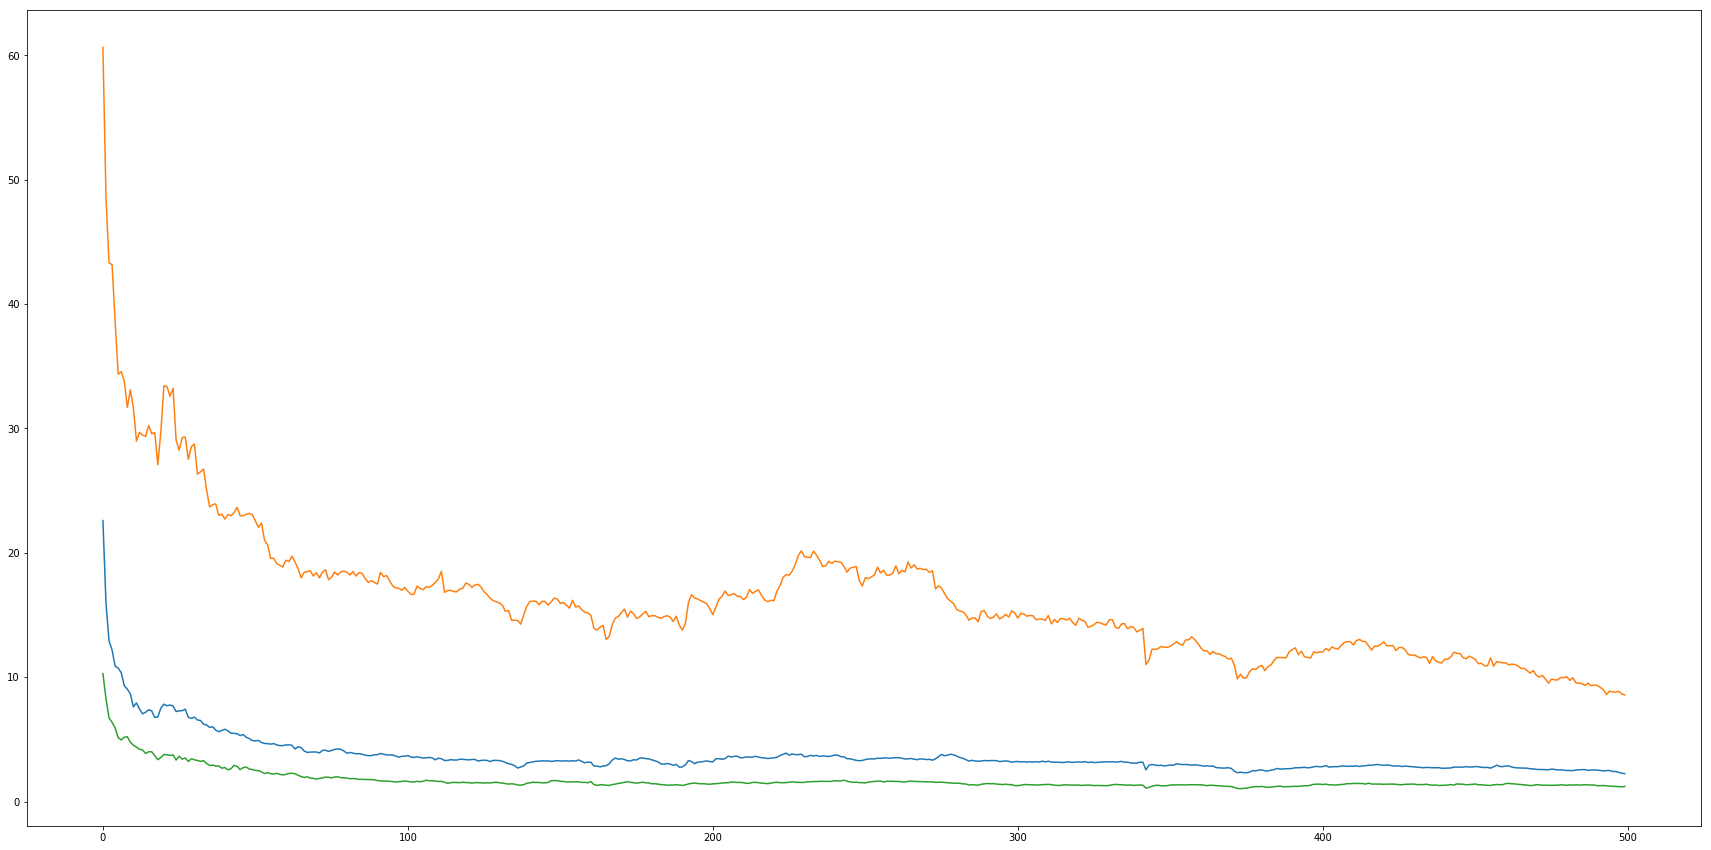

In [65]:
fig, ax = plt.subplots(figsize=(30, 15))
ax.plot(df_awp.index[:500], df_awp.median_sell_price[:500])
ax.plot(df_m4.index[:500], df_m4.median_sell_price[:500])
ax.plot(df_p2k.index[:500], df_p2k.median_sell_price[:500])

### Okay, my release date was mislabeled. "P2000 | Imperial" matched "P2000 | Imperial Dragon" and labeled both as releasing on the same day. At least the clustering works.

---

### Maybe every item looks the same? Let's look at examples of 5 random items to see how they compare

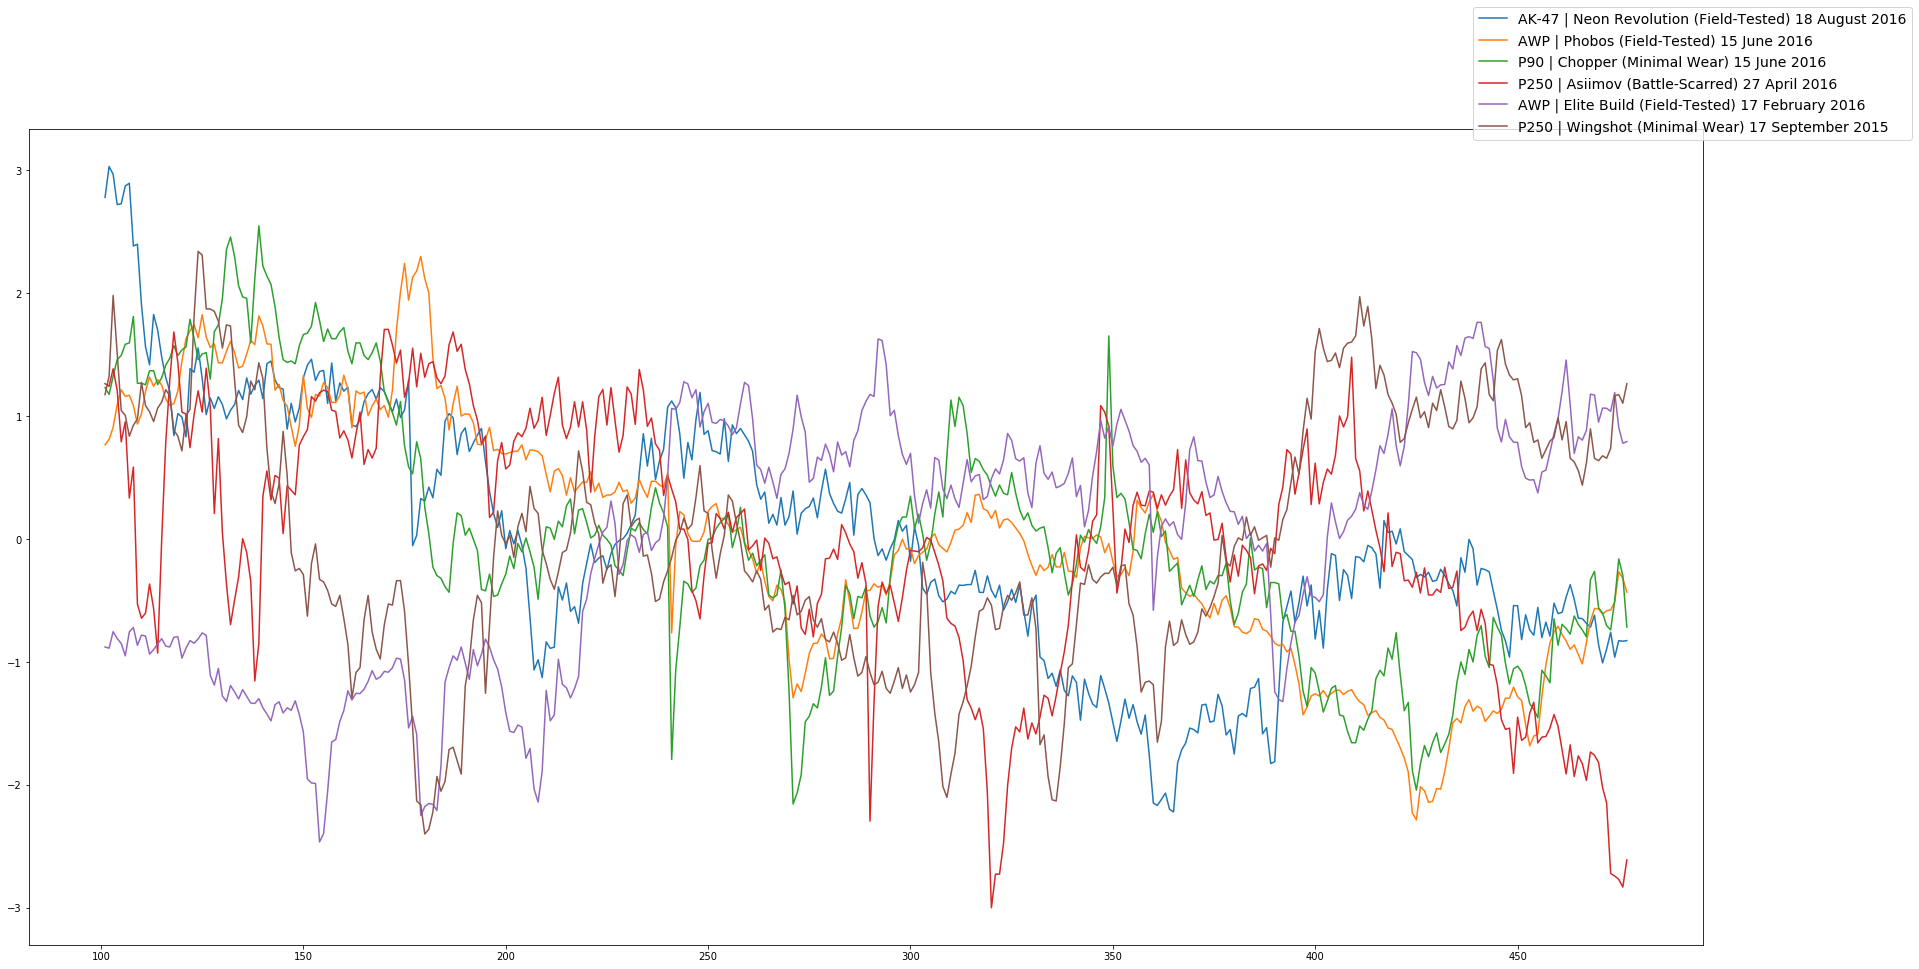

In [141]:
fig, ax = plt.subplots(figsize=(30, 15))
for x in np.random.random_integers(0, len(df_standard)-1, 6):
    ax.plot(df_standard.iloc[x], label=df_standard.index[x])
_=fig.legend(fontsize=14)

### Trying out KMeans clustering

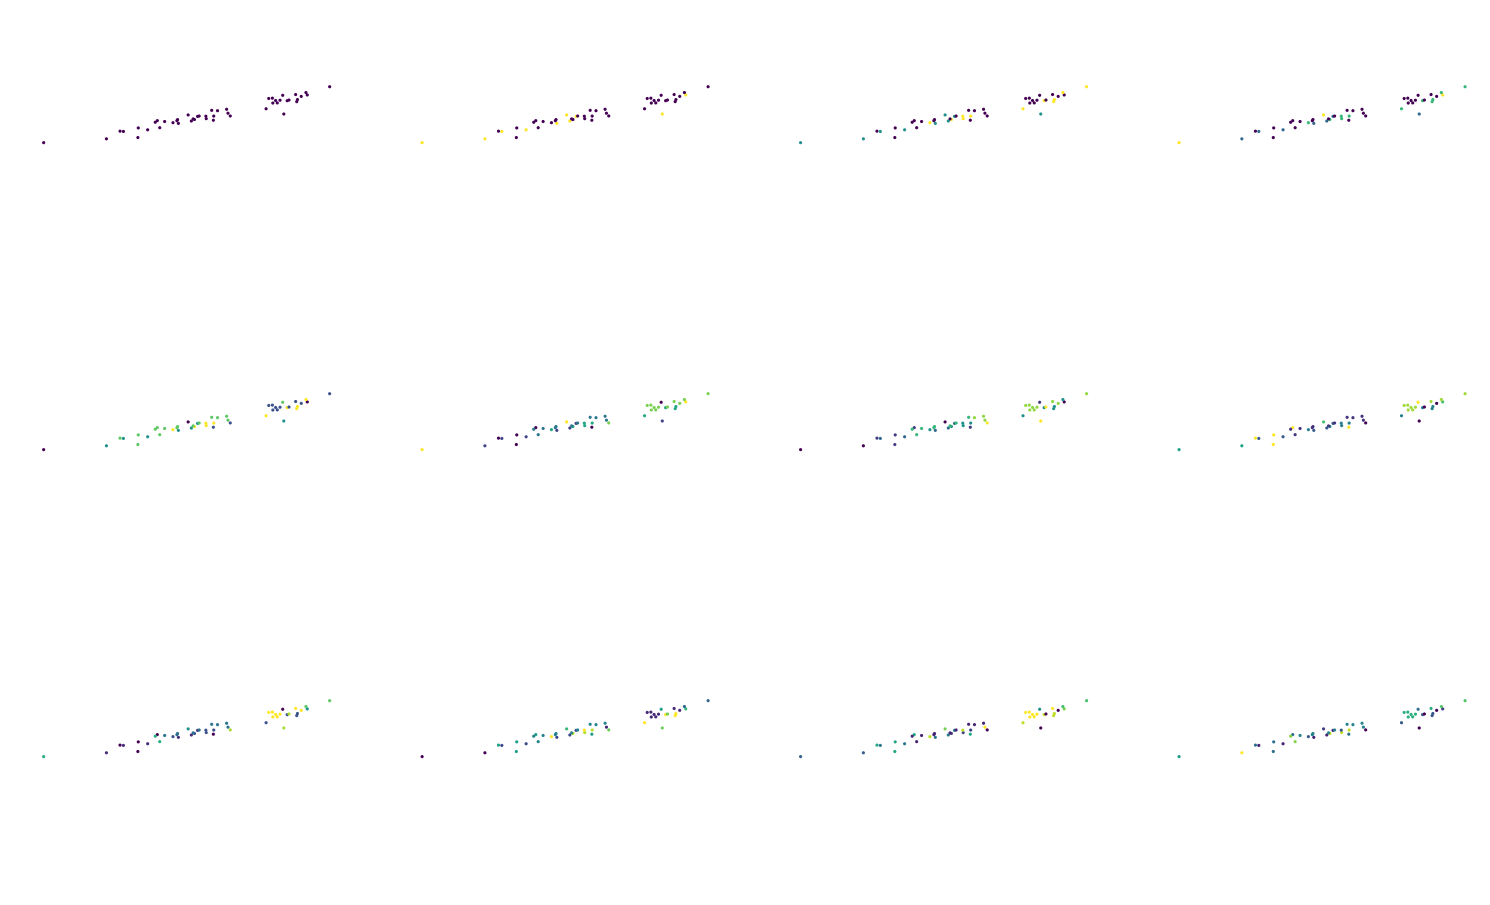

In [66]:
x = df_pivot_norm
maxk = 30
wcss = np.zeros(maxk)
silhouette = np.zeros(maxk)

fig, axes = plt.subplots(3, 4, figsize=(26,16))

# flatten
axes = [ax for axrow in axes for ax in axrow]

for k, ax in zip(range(1,maxk), axes):
    km = KMeans(k)
    y = km.fit_predict(x)
    ax.axis('off')
    ax.scatter(x[:,0], x[:,1], c=y, linewidths=0, s=10)
    ax.set_ylim(ymin=-9, ymax=8)
    
    
    for c in range(0, k):
        for i1, i2 in itertools.combinations([ i for i in range(len(y)) if y[i] == c ], 2):
            wcss[k] += sum(x[i1] - x[i2])**2
    wcss[k] /= 2
    
    if k > 1:
        silhouette[k] = silhouette_score(x,y)

Text(0,0.5,'silhouette score')

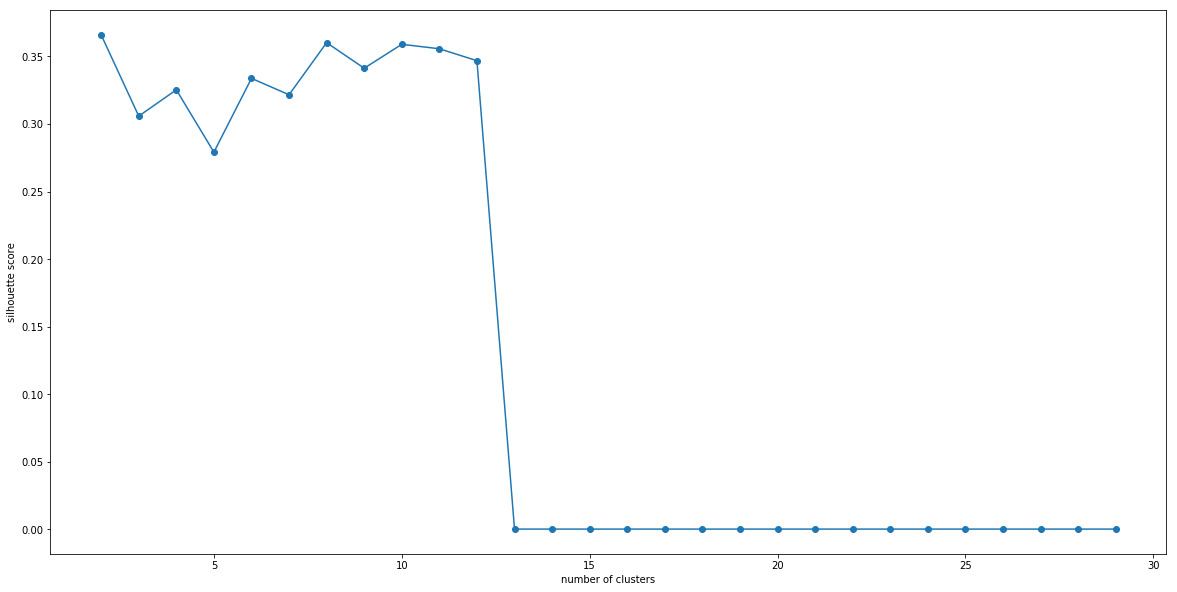

In [67]:
fig, ax = plt.subplots(figsize=(20,10))
ax.plot(range(2,30), silhouette[2:30], 'o-')
ax.set_xlabel("number of clusters")
ax.set_ylabel("silhouette score")
#ax.set_ylim(ymin=0.0, ymax=1.0)

### After 12 clusters it drops to 0. I think the feature space is too large for KMeans. 

---

In [89]:
from src.dendrogram_class import Dendrogram, make_dendrogram, mask_mins

In [78]:
with open('../data/archive/csgo_features.pkl', 'rb') as f:
    df = pickle.load(f)

In [79]:
df.head()

,app,date,item_name,median_sell_price,quantity,release_date,parenthetical,gun_bool,StatTrak,souvenir,gun_type,skin,quality,keys,capsules,stickers,event_item,days_since_release
0,730,1.471583e+09,Glock-18 | Weasel (Battle-Scarred),6.193,135,18 August 2016,True,True,False,False,Glock-18,Weasel,Battle-Scarred,False,False,False,False,0
1,730,1.471669e+09,Glock-18 | Weasel (Battle-Scarred),5.103,166,18 August 2016,True,True,False,False,Glock-18,Weasel,Battle-Scarred,False,False,False,False,1
2,730,1.471756e+09,Glock-18 | Weasel (Battle-Scarred),4.721,142,18 August 2016,True,True,False,False,Glock-18,Weasel,Battle-Scarred,False,False,False,False,2
3,730,1.471842e+09,Glock-18 | Weasel (Battle-Scarred),4.302,98,18 August 2016,True,True,False,False,Glock-18,Weasel,Battle-Scarred,False,False,False,False,3
4,730,1.471928e+09,Glock-18 | Weasel (Battle-Scarred),3.898,125,18 August 2016,True,True,False,False,Glock-18,Weasel,Battle-Scarred,False,False,False,False,4


In [80]:
df.release_date.unique()

array(['18 August 2016', '17 February 2016', '27 April 2016', nan,
       '26 May 2015', '14 September 2017', '8 December 2015',
       '15 April 2015', '15 March 2017', '20 February 2014',
       '28 November 2016', '27 November 2013', '18 December 2013',
       '17 September 2015', '15 June 2016', '1 May 2014',
       '15 February 2018', '8 January 2015', '14 August 2013',
       '8 November 2013', '23 May 2017', '1 July 2014', '8 August 2014',
       '19 September 2013', '11 November 2014', '12 February 2014',
       '10 July 2014'], dtype=object)

In [81]:
df['num_sale_days'] = df.groupby('item_name')['days_since_release'].transform('max')
df['desc'] = df['item_name'] + ' ' + df['release_date']
# df_pivot = df_sub.reset_index().pivot('desc', 'num_sales_days', 'median_sell_price')

In [84]:
den = Dendrogram()
den.fit(df)

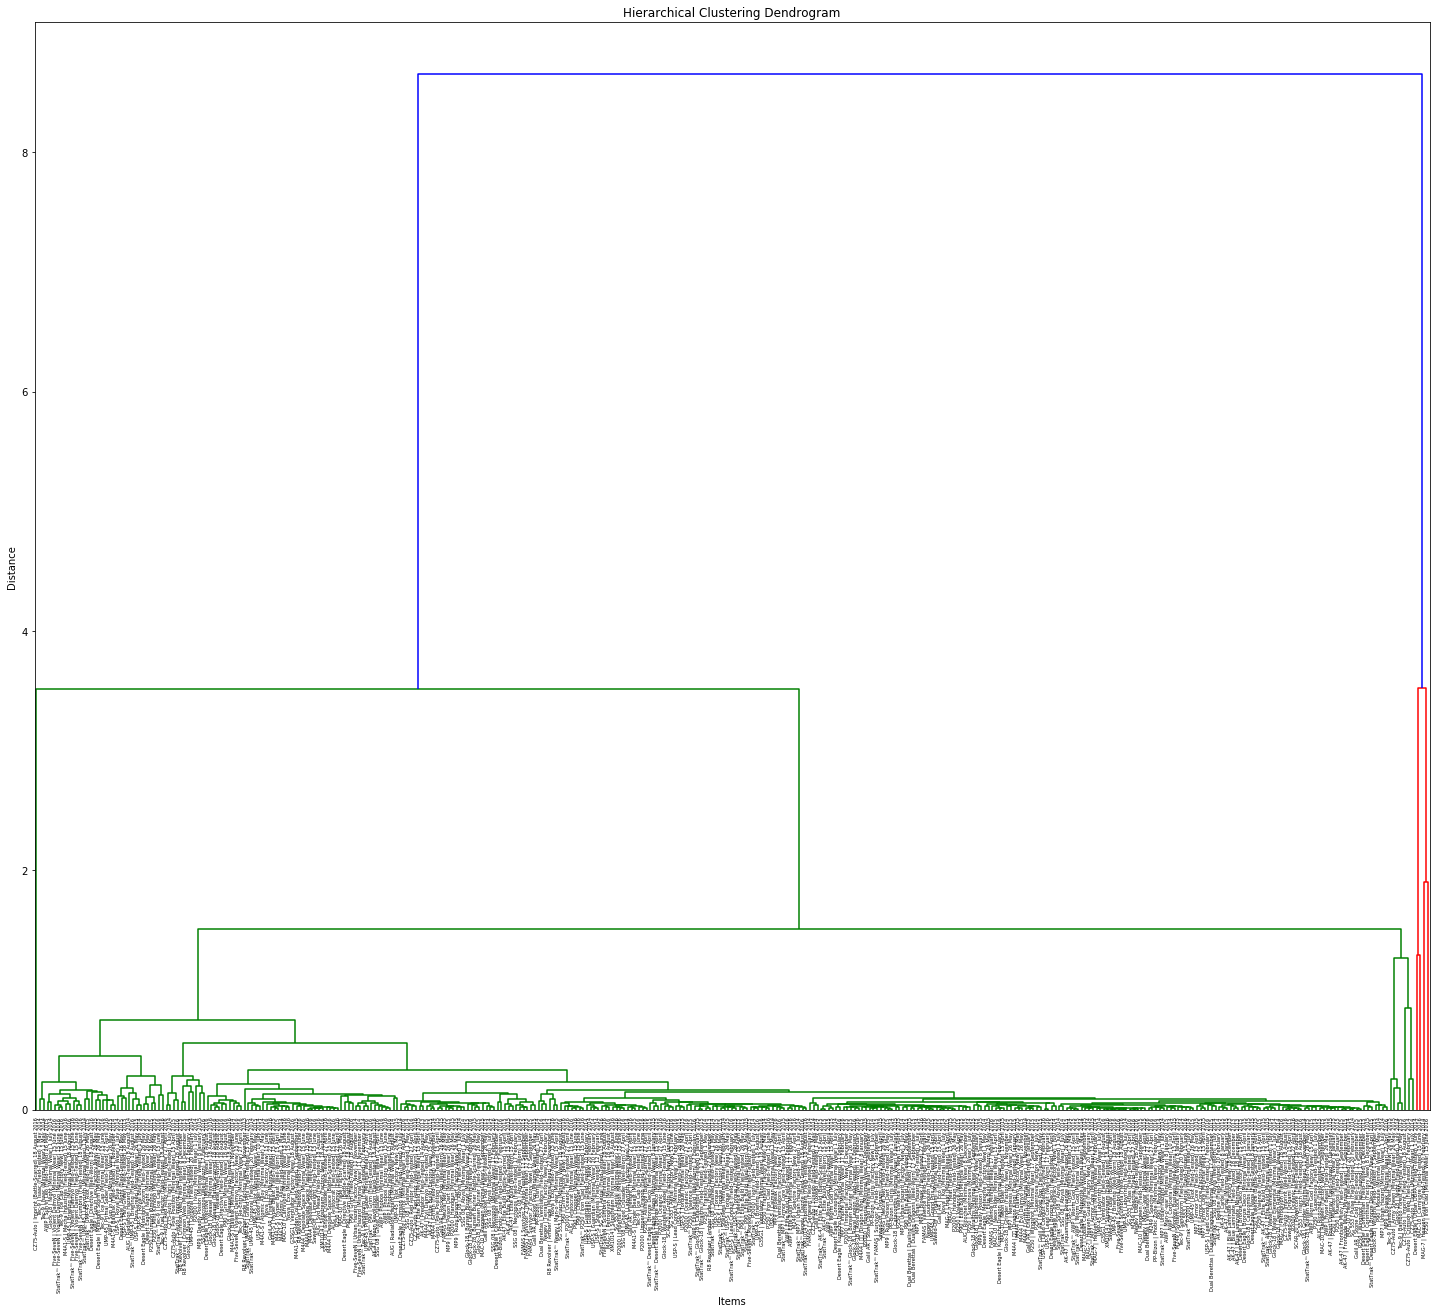

In [85]:
den.make_dendrogram(save=False)

### These two items were tightly clustered but weren't released on the same day

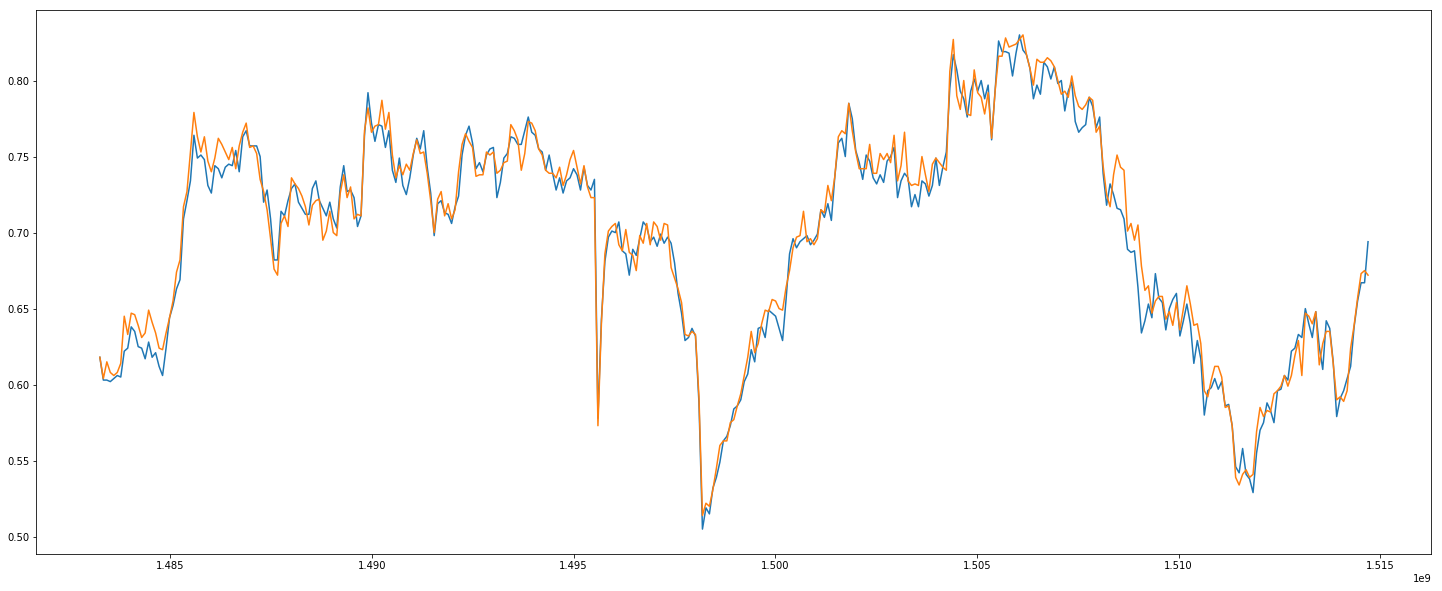

In [90]:
fig, ax = plt.subplots(figsize=(25,10))
ax.plot(den.pivot.loc['StatTrak™ Glock-18 | Catacombs (Field-Tested) 8 January 2015'])
ax.plot(den.pivot.loc['StatTrak™ Glock-18 | Wraiths (Field-Tested) 17 September 2015'])

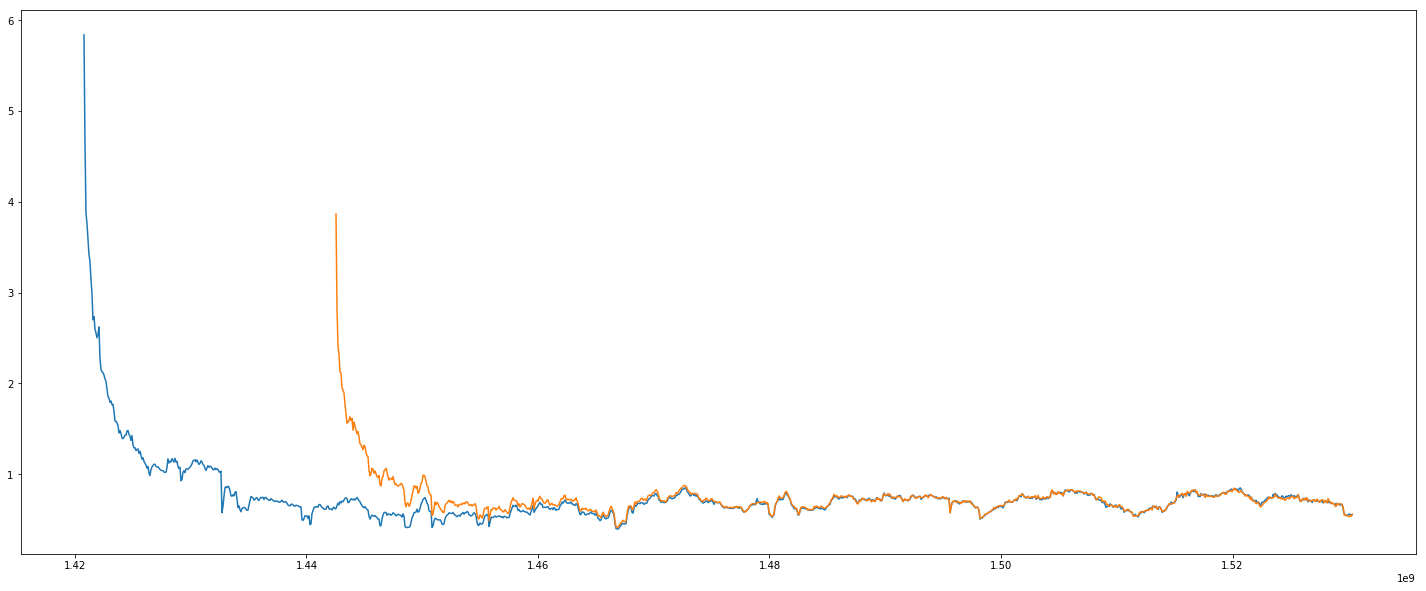

In [91]:
fig, ax = plt.subplots(figsize=(25,10))
ax.plot(df[df.item_name=='StatTrak™ Glock-18 | Catacombs (Field-Tested)'].date, df[df.item_name=='StatTrak™ Glock-18 | Catacombs (Field-Tested)'].median_sell_price)
ax.plot(df[df.item_name=='StatTrak™ Glock-18 | Wraiths (Field-Tested)'].date, df[df.item_name=='StatTrak™ Glock-18 | Wraiths (Field-Tested)'].median_sell_price)

### Looking at date cutoffs for removing the first few days of sale

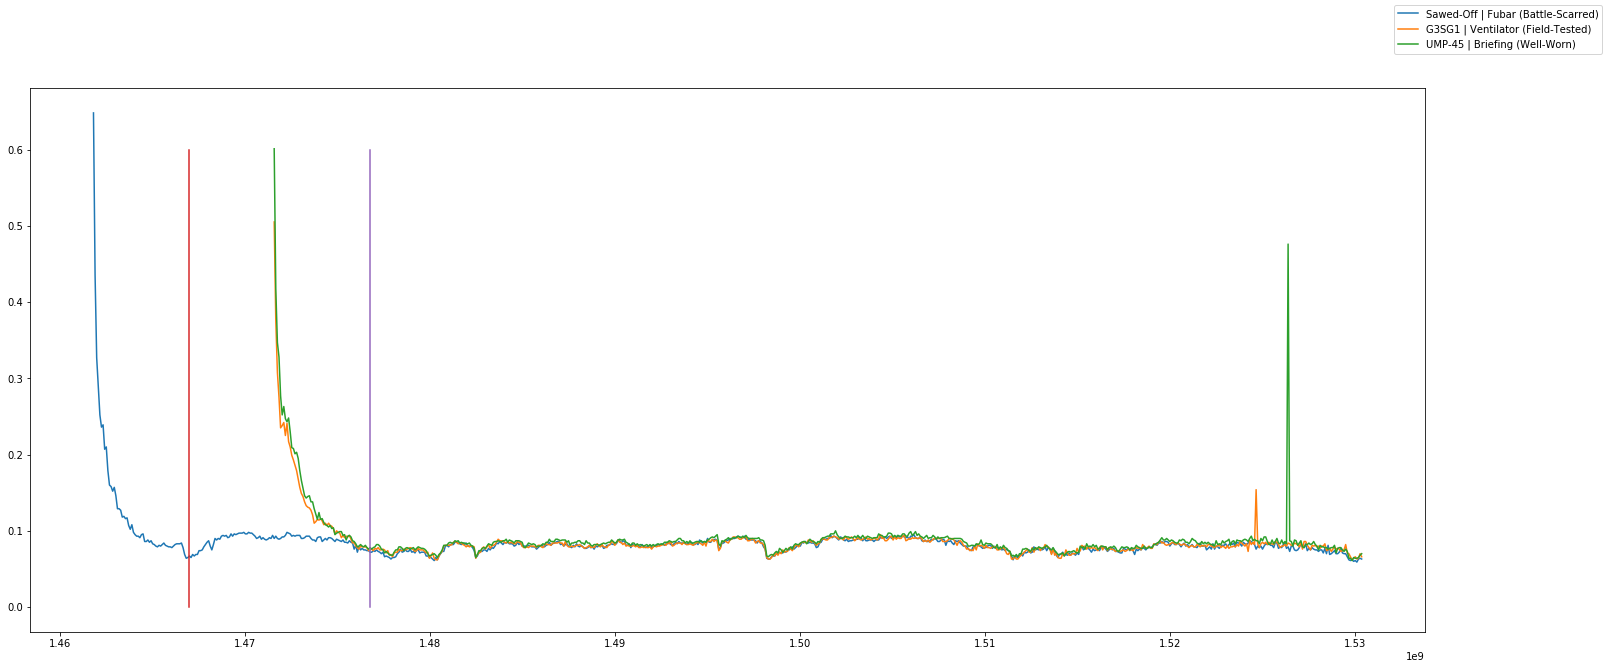

In [92]:
fig, ax = plt.subplots(figsize=(25,10))
ax.plot(df[df.item_name=='Sawed-Off | Fubar (Battle-Scarred)'].date, df[df.item_name=='Sawed-Off | Fubar (Battle-Scarred)'].median_sell_price, label='Sawed-Off | Fubar (Battle-Scarred)')
ax.plot(df[df.item_name=='G3SG1 | Ventilator (Field-Tested)'].date, df[df.item_name=='G3SG1 | Ventilator (Field-Tested)'].median_sell_price, label='G3SG1 | Ventilator (Field-Tested)')
ax.plot(df[df.item_name=='UMP-45 | Briefing (Well-Worn)'].date, df[df.item_name=='UMP-45 | Briefing (Well-Worn)'].median_sell_price, label='UMP-45 | Briefing (Well-Worn)')
ax.plot([df[df.item_name=='Sawed-Off | Fubar (Battle-Scarred)'].date.values[60]]*2, [0, 0.6])
ax.plot([df[df.item_name=='UMP-45 | Briefing (Well-Worn)'].date.values[60]]*2, [0, 0.6])
fig.legend()